In [13]:
import pandas as pd


In [14]:
df = pd.read_csv("/content/phishing_site_urls.csv")
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [15]:
df.info()
df["Label"].value_counts(normalize=True) * 100


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


,proportion
Label,
good,71.525778
bad,28.474222


In [16]:
df["Label"] = df["Label"].map({"good": 0, "bad": 1})


In [17]:
import re

def clean_url(url):
    url = url.lower()
    url = re.sub(r"https?://|www\.", "", url)
    url = re.sub(r"[^a-z0-9./-]", "", url)
    return url

df["clean_url"] = df["URL"].apply(clean_url)


In [18]:
def extract_features(url):
    return [
        len(url),
        url.count('.'),
        url.count('-'),
        url.count('/'),
        sum(c.isdigit() for c in url),
        int(bool(re.search(r"\d+\.\d+\.\d+\.\d+", url))),
        int("https" in url)
    ]


In [19]:
import numpy as np

url_features = np.array(df["clean_url"].apply(extract_features).tolist())


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    max_features=3000
)

tfidf_features = tfidf.fit_transform(df["clean_url"])


In [21]:
from scipy.sparse import hstack

X = hstack([tfidf_features, url_features])
y = df["Label"]


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [23]:
class_weight = {0: 1, 1: 2}


In [24]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    class_weight=class_weight,
    n_jobs=-1,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=30,
                       n_estimators=300, n_jobs=-1, random_state=42)

In [25]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.95      0.96      0.95     78585
           1       0.89      0.86      0.87     31285

    accuracy                           0.93    109870
   macro avg       0.92      0.91      0.91    109870
weighted avg       0.93      0.93      0.93    109870

ROC-AUC: 0.9726495880381614


In [29]:
threshold = 0.4
y_custom = (y_prob >= threshold).astype(int)

print(classification_report(y_test, y_custom))


              precision    recall  f1-score   support

           0       0.96      0.92      0.94     78585
           1       0.81      0.91      0.86     31285

    accuracy                           0.91    109870
   macro avg       0.89      0.91      0.90    109870
weighted avg       0.92      0.91      0.92    109870



In [30]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.9291708382634022


In [28]:
from sklearn.metrics import recall_score

recall_phishing = recall_score(y_test, y_pred)
print("Recall (Phishing class):", recall_phishing)


Recall (Phishing class): 0.860444302381333


In [31]:
recall_phishing_custom = recall_score(y_test, y_custom)
print("Recall after threshold tuning:", recall_phishing_custom)


Recall after threshold tuning: 0.9094454211283363


In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm


array([[75169,  3416],
       [ 4366, 26919]])

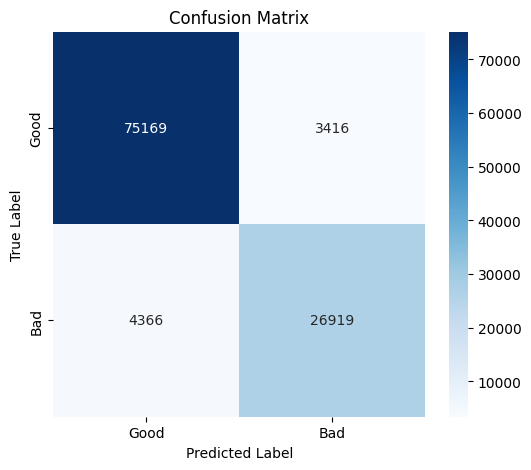

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Good", "Bad"],
    yticklabels=["Good", "Bad"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


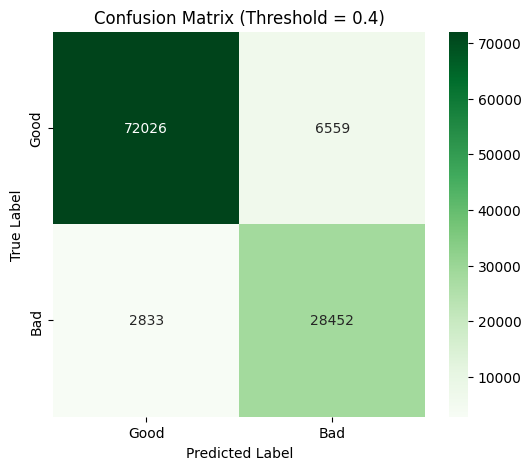

In [34]:
cm_custom = confusion_matrix(y_test, y_custom)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_custom,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Good", "Bad"],
    yticklabels=["Good", "Bad"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Threshold = 0.4)")
plt.show()


In [35]:
import joblib

joblib.dump(model, "phishing_rf_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [36]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(
    class_weight={0: 1, 1: 2},
    max_iter=1000,
    n_jobs=-1,
    solver="lbfgs"
)

log_model.fit(X_train, y_train)


LogisticRegression(class_weight={0: 1, 1: 2}, max_iter=1000, n_jobs=-1)

In [37]:
y_pred_lr = log_model.predict(X_test)
y_prob_lr = log_model.predict_proba(X_test)[:, 1]


In [38]:
from sklearn.metrics import accuracy_score

lr_accuracy = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Test Accuracy:", lr_accuracy)


Logistic Regression Test Accuracy: 0.9294984982251752


In [39]:
from sklearn.metrics import classification_report

print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     78585
           1       0.86      0.90      0.88     31285

    accuracy                           0.93    109870
   macro avg       0.91      0.92      0.91    109870
weighted avg       0.93      0.93      0.93    109870



In [40]:
from sklearn.metrics import roc_auc_score

lr_roc_auc = roc_auc_score(y_test, y_prob_lr)
print("Logistic Regression ROC-AUC:", lr_roc_auc)


Logistic Regression ROC-AUC: 0.978057668749424


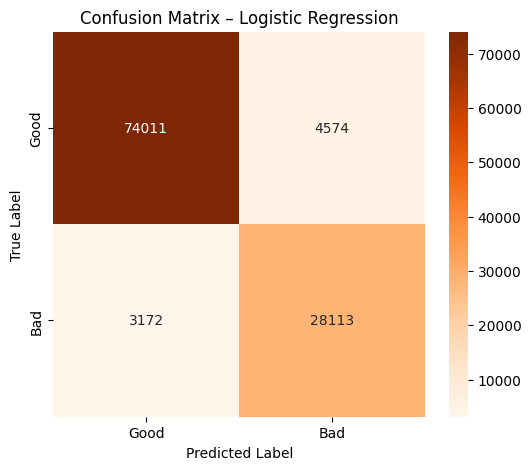

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_lr,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=["Good", "Bad"],
    yticklabels=["Good", "Bad"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()


In [42]:
from sklearn.metrics import recall_score

lr_recall = recall_score(y_test, y_pred_lr)
print("Logistic Regression Recall (Phishing):", lr_recall)


Logistic Regression Recall (Phishing): 0.8986095572958287


In [43]:
threshold_lr = 0.4
y_custom_lr = (y_prob_lr >= threshold_lr).astype(int)

print("Threshold Tuned Classification Report (LR)")
print(classification_report(y_test, y_custom_lr))


Threshold Tuned Classification Report (LR)
              precision    recall  f1-score   support

           0       0.97      0.92      0.94     78585
           1       0.81      0.93      0.87     31285

    accuracy                           0.92    109870
   macro avg       0.89      0.92      0.90    109870
weighted avg       0.93      0.92      0.92    109870



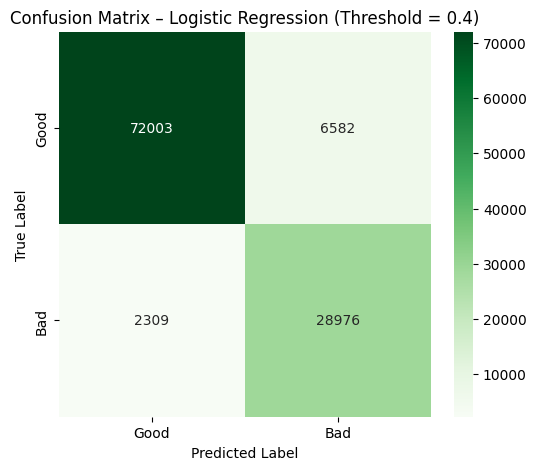

In [44]:
cm_lr_custom = confusion_matrix(y_test, y_custom_lr)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_lr_custom,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Good", "Bad"],
    yticklabels=["Good", "Bad"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Logistic Regression (Threshold = 0.4)")
plt.show()


In [45]:
import joblib

joblib.dump(log_model, "phishing_logistic_model.pkl")


['phishing_logistic_model.pkl']